We will download a public scRNA-seq dataset from [GEO(GSE163701)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE163701). The following code lines will store the files to `data` directory.

In [ ]:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE163701
dir.create("data", showWarnings = F)
curl::curl_download(
  "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE163701&format=file",
  "data/GSE163701_RAW.tar")
untar("data/GSE163701_RAW.tar", exdir = "data/")

This tutorial requires using the following packages, so we need to install the packages using `install.packages` function as follows (**NOTE:** it will take time): 

In [ ]:
install.packages(c("Seurat", "tidyverse", "openxlsx"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Four packages - `Seurat`, `glue`, `tidyverse`, and `openxlsx` are required, and we will import the packages using `library` function.

The last line is to change the size of all figures in the notebook.

In [ ]:
library(Seurat)
library(glue)
library(tidyverse)
library(openxlsx)
options(repr.plot.width=12, repr.plot.height=8)

`get_obj_mtx` is a helper function to load a single scRNA-seq sample and calculate basic statistics (e.g., mitocondria gene perecentage), then return a Seurat object.

In [ ]:
get_obj_mtx <- function(prefix, id) {
  mtx <- ReadMtx(mtx = "{prefix}_matrix.mtx.gz" %>% glue,
                 cells = "{prefix}_barcodes.tsv.gz" %>% glue,
                 features = "{prefix}_features.tsv.gz" %>% glue)
  
  obj <- CreateSeuratObject(mtx, id)
  obj[["percent.mito"]] <- PercentageFeatureSet(obj, pattern = "^mt-")
  obj  
}

We load two samples (`PBS` and `DCAN`) and add them to `sc_objs` list.

In [ ]:
sc_objs <- list()
sc_objs$PBS <- get_obj_mtx("data/GSM4984081_SAT_PBS", "PBS")
sc_objs$DCAN <- get_obj_mtx("data/GSM4984080_SAT_D-CAN", "DCAN")

sc_objs

$PBS
An object of class Seurat 
31053 features across 2851 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)

$DCAN
An object of class Seurat 
31053 features across 1922 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)


`merge` is a function to merge multiple Seurat objects. If you have more than two, you need to add a vector of Seurat objects like `y=c(obj_a, obj_b, ...)`. The following figure displays summary statistics for each data, 

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


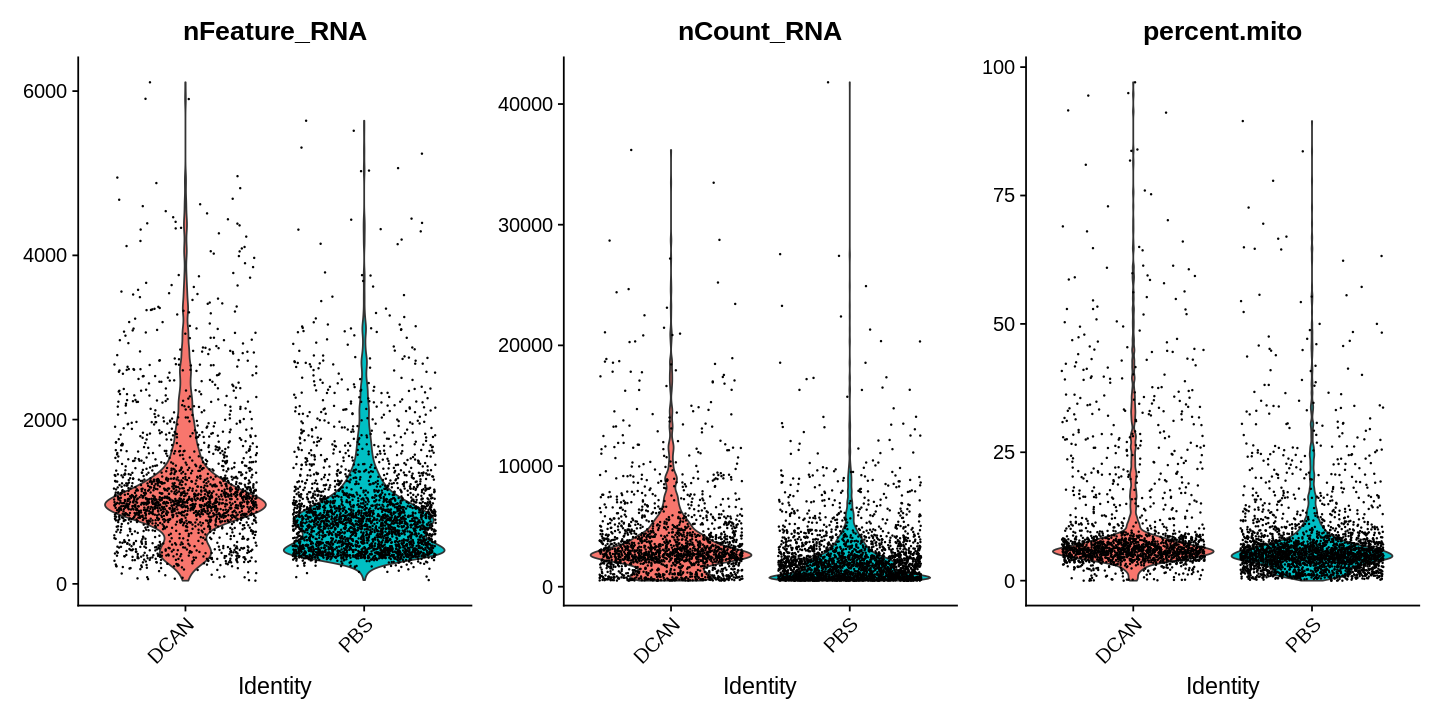

In [ ]:
merge(x=sc_objs$PBS, y=c(sc_objs$DCAN)) %>% 
  VlnPlot(
    features = c(
      "nFeature_RNA",
      "nCount_RNA",
      "percent.mito"
    )
  )

You would check the data quality by drawing pairwise scatter plot of the summary features, and we are expecting that:

* a high correlation between `nCount_RNA` and `nFeature_RNA`
* not a significant correlation between `nCount_RNA` and `nFeature`.

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


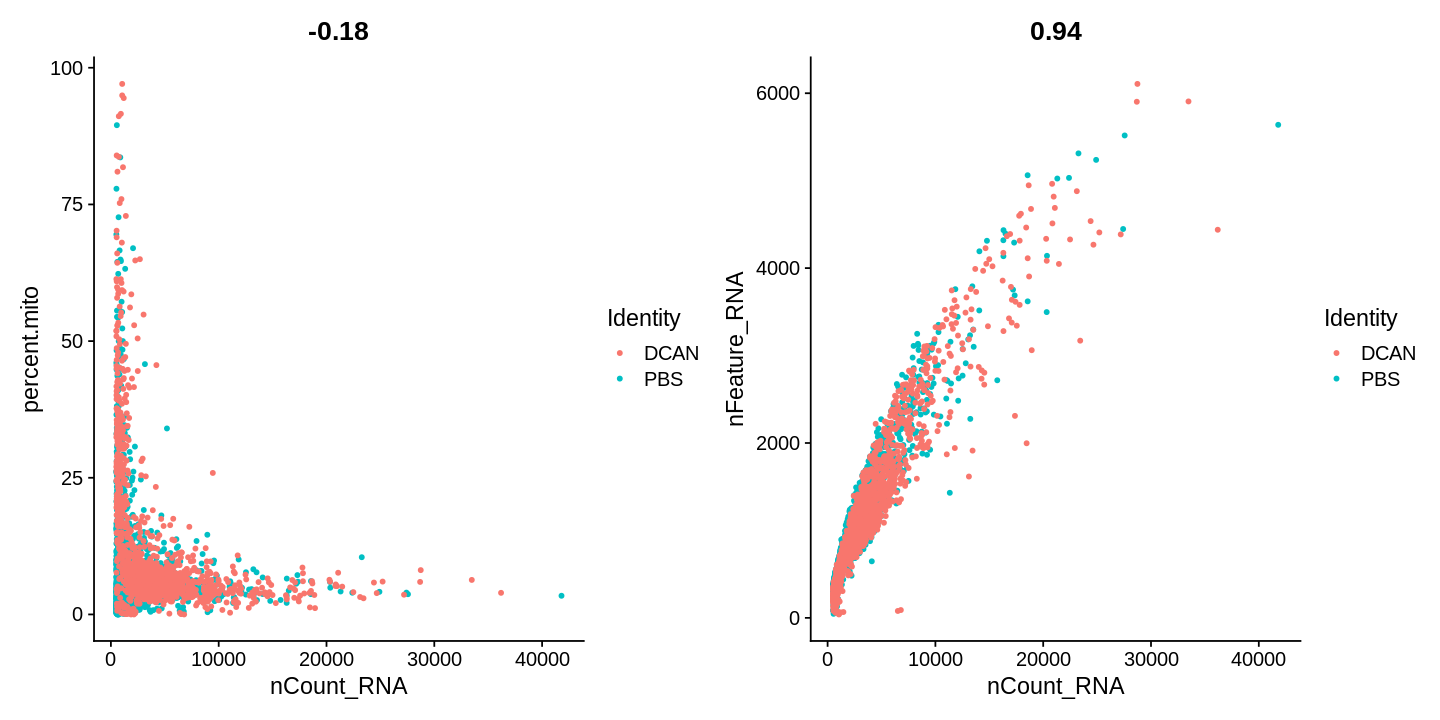

In [ ]:
sc_merge <- merge(x=sc_objs$PBS, y=c(sc_objs$DCAN)) 

plot1 <- FeatureScatter(sc_merge, feature1 = "nCount_RNA", feature2 = "percent.mito")
plot2 <- FeatureScatter(sc_merge, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

The following code will filter out some cells by the defined criteria (see the 3th line), then normalize and find highly variable genes for each sample.

In [ ]:
sc_filtered <- lapply(X = sc_objs, function(x) {
  x %>% 
    subset(nFeature_RNA >= 100 & nFeature_RNA <= 2000 & percent.mito <= 20 & nCount_RNA <= 50000 ) %>% 
    NormalizeData() %>% 
    FindVariableFeatures(selection.method = "vst", nfeatures = 2000)
})

Excuting the same code for the summary plot will display the result after the filteration.

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


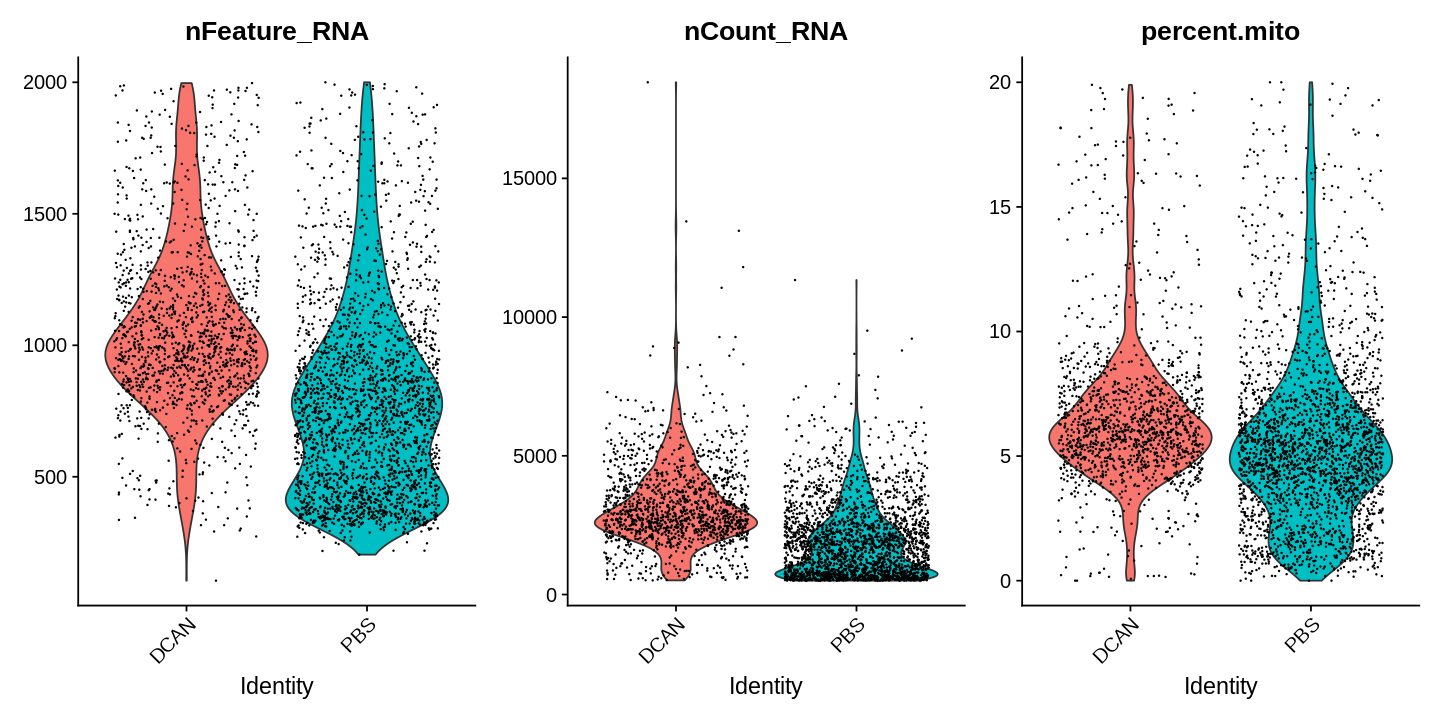

In [ ]:
merge(x=sc_filtered$PBS, y=c(sc_filtered$DCAN)) %>% 
  VlnPlot(
    features = c(
      "nFeature_RNA",
      "nCount_RNA",
      "percent.mito"
    )
  )

We have to be very careful to integrate multiple samples. Specifically, sequencing the same samples with different batches can confound your further analysis. The following integration step is a way to deal with a potential confounding effect.

In [ ]:
sc_anchors <- FindIntegrationAnchors(sc_filtered, dims = 1:20)
sc_combined <- IntegrateData(anchorset = sc_anchors, dims = 1:20)

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4219 anchors

Filtering anchors

	Retained 3383 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [ ]:
sc_combined

An object of class Seurat 
33053 features across 3975 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

The following step may be required to proceed the dimension reduction of the data (PCA). scRNA-seq data are a high-dimensional and noisy, and performing dimension reduction is benefitial to increase signal-to-noise ratio.

In [ ]:
DefaultAssay(sc_combined) <- "RNA"
sc_combined <- sc_combined %>% 
  FindVariableFeatures() %>% # find highly variable genes
  ScaleData(vars.to.regress = c("nCount_RNA", "percent.mito")) 
# scaling data by a regression  

# Change Assay to integrated 
DefaultAssay(sc_combined) <- "integrated"

Regressing out nCount_RNA, percent.mito

Centering and scaling data matrix



`RunPCA` will perform PCA on the combined dataset, and idenfiying the number of PCs is a key for further steps. Displaying `ElbowPlot` would give an insight, and the following plot suggested that the first 25 PC would be informative.

Centering and scaling data matrix

PC_ 1 
Positive:  Ighm, Rplp1, Rplp0, Igkc, Cd69, H2-Aa, H2-Ab1, Ms4a1, Cd79a, Iglc2 
	   Cd74, Cd79b, Dusp2, Ighd, Ly6d, Trbc2, Bank1, Cd3g, Fcmr, Cd3d 
	   Iglc3, Rel, Ms4a6b, Fcer2a, Hcst, Gpr183, Slamf6, Mzb1, Cd3e, Ccr7 
Negative:  Sparc, Ifitm3, Igfbp7, Fabp4, Ly6c1, Cavin1, Cxcl12, Cd36, Cav1, Timp3 
	   Plpp3, Hspb1, Cavin2, Tm4sf1, Rbp7, Mgll, Sparcl1, Epas1, Egfl7, Gng11 
	   Ly6a, Col4a1, Ptprb, Flt1, Cdh5, App, Nfib, Ifitm2, Kitl, Gpihbp1 
PC_ 2 
Positive:  Cd36, Rbp7, Mgll, Fabp4, Gpihbp1, Cdh5, Cd300lg, Adgrf5, Cavin2, Egfl7 
	   Cldn5, Flt1, Ptprb, Kdr, Cav1, Id1, Epas1, Esam, Slc9a3r2, Fabp5 
	   Cyyr1, Btnl9, Pecam1, Tm4sf1, Palmd, Afdn, Kitl, Rflnb, Timp4, Cav2 
Negative:  Dcn, Col1a2, Col3a1, Col1a1, Aebp1, Clec3b, Serping1, Igfbp6, Mfap5, C3 
	   Gsn, Fn1, Dpt, Serpinf1, Fstl1, Rnase4, Mmp2, Ogn, Timp2, Dpep1 
	   Col5a2, Rarres2, Tnxb, Sema3c, Lum, Pi16, Cd248, Fbn1, Efemp1, Htra1 
PC_ 3 
Positive:  Trbc2, Cd3g, Cd3d, Fyb, Cd3e, T

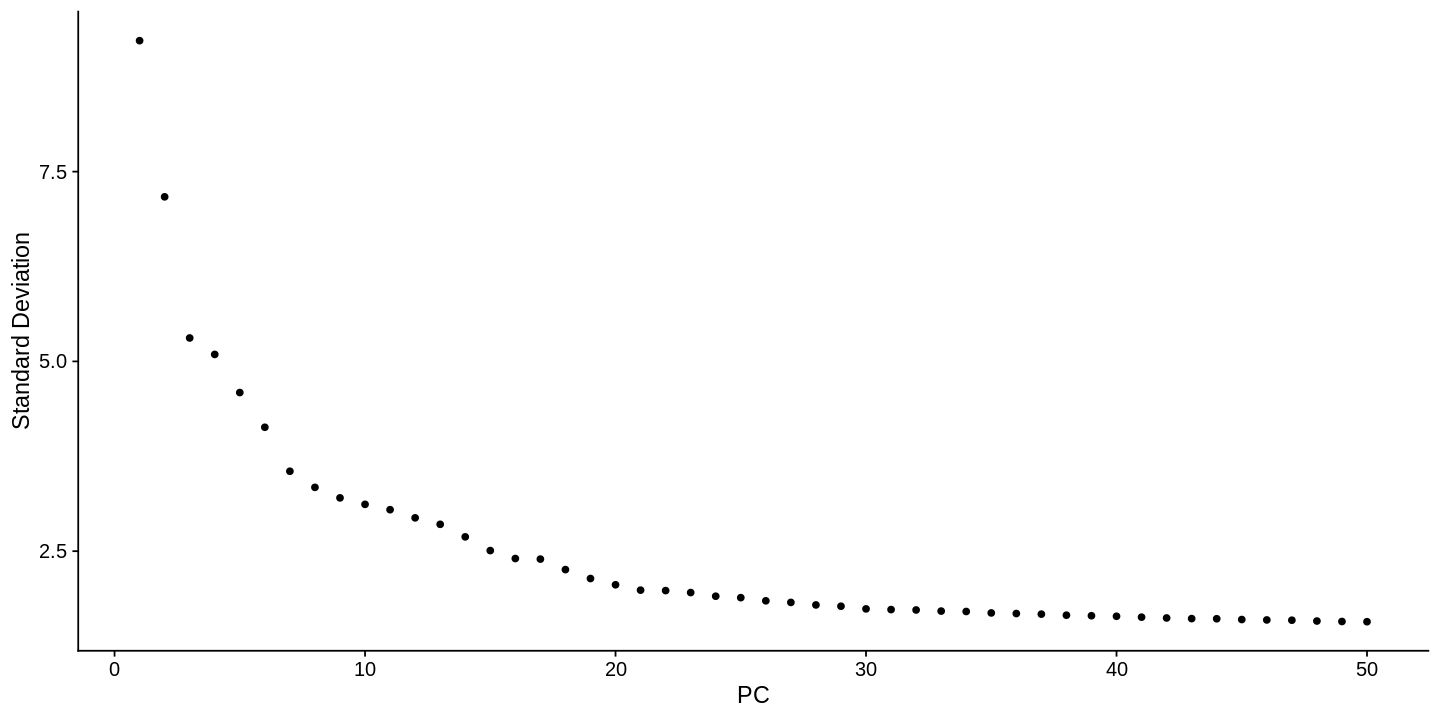

In [ ]:
ㅅsc_combined <- sc_combined %>% 
  ScaleData %>% 
  RunPCA(npcs = 50)

ElbowPlot(sc_combined, ndims = 50)

The next step is to cluster the cells based on the assumption. The same type of cells have similiar gene expression patterns, and cells from different cell types have different gene expression patterns. The key parameter of the step is`resolution` in the `FindClusters`, and it is recommended to set the parameters as follows:

* If you expect general cell types, set a low resolution.
* If you expect many sub-types of cells, you may need to set a high resolution.

In the following code, we also use `RunUMAP` to manifold the cell to a very low dimension (e.g. 2-dimension).

In [ ]:
sc_combined <- sc_combined %>% 
  RunUMAP(reduction = "pca", dims = 1:25) %>% 
  FindNeighbors(reduction = "pca", dims = 1:25) %>% 
  FindClusters(resolution = 0.5)

18:29:34 UMAP embedding parameters a = 0.9922 b = 1.112

18:29:34 Read 3975 rows and found 25 numeric columns

18:29:34 Using Annoy for neighbor search, n_neighbors = 30

18:29:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:29:35 Writing NN index file to temp file /tmp/RtmpUObPXj/file6502749c25ab

18:29:35 Searching Annoy index using 1 thread, search_k = 3000

18:29:37 Annoy recall = 100%

18:29:37 Commencing smooth kNN distance calibration using 1 thread

18:29:38 Initializing from normalized Laplacian + noise

18:29:38 Commencing optimization for 500 epochs, with 166720 positive edges

18:29:44 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3975
Number of edges: 150556

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8987
Number of communities: 19
Elapsed time: 0 seconds


`Dimplot` will display the clustering result with UMAP result. Repeating clustering and plotting is a common step to find the optimal parameter for the dataset.

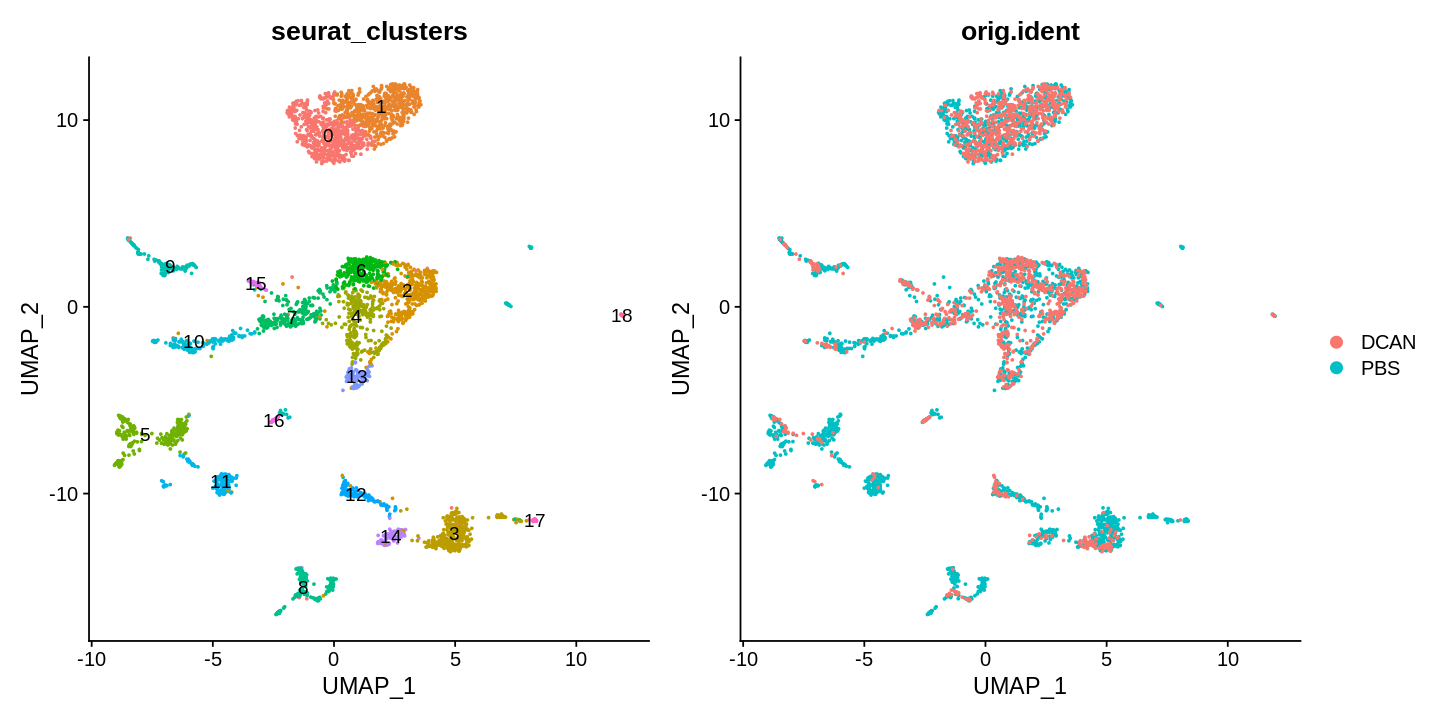

In [ ]:
plot1 <- DimPlot(sc_combined, reduction = "umap", group.by = "seurat_clusters", label=T) + theme(legend.position = "none")
plot2 <- DimPlot(sc_combined, reduction = "umap", group.by = "orig.ident")
plot1 + plot2

If you have multiple groups and want to see cell proportion by groups, you can use `split.by` parameter.

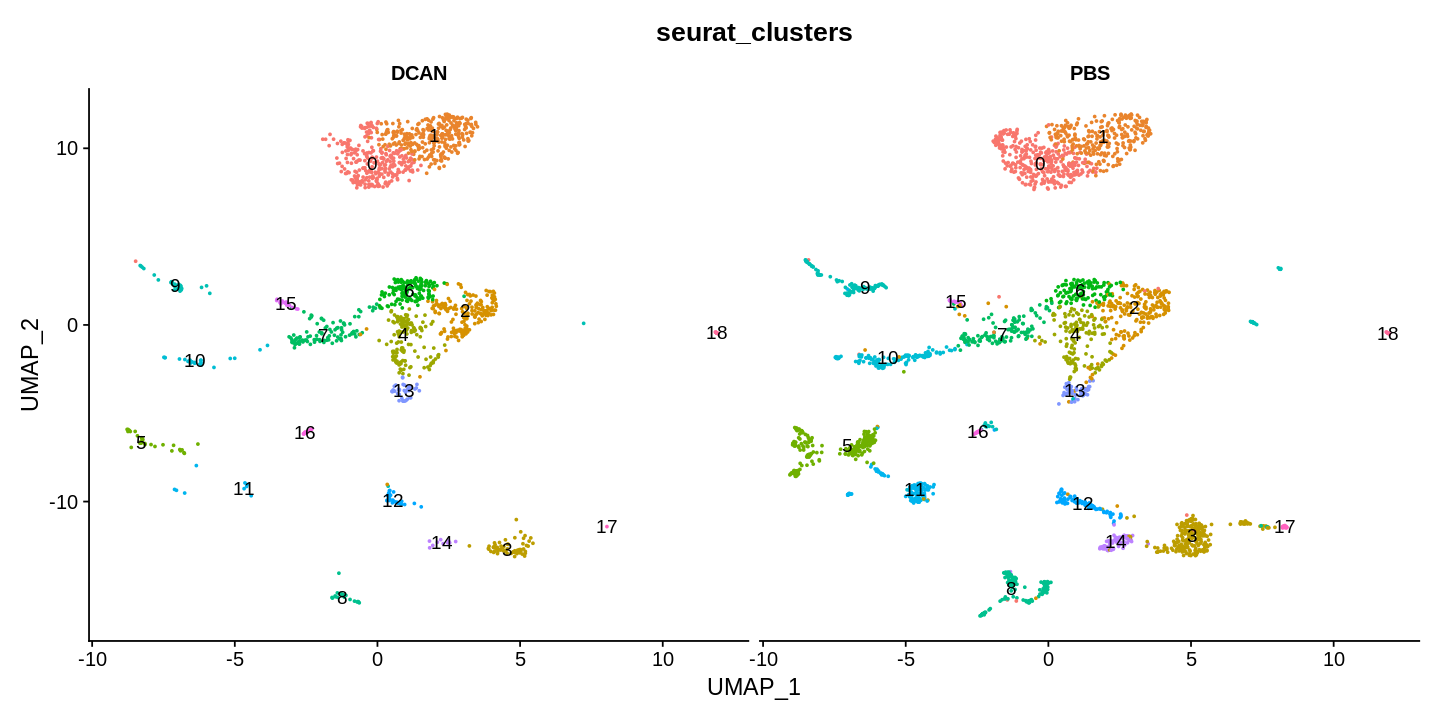

In [ ]:
DimPlot(sc_combined, reduction = "umap", split.by = "orig.ident", group.by = "seurat_clusters", label=T) +  
  theme(legend.position = "none") 

The next step is finding candidates of marker genes of each cluster. We normally define a marker gene of a cluster as follows:
* The gene has to be expressed substantially. (`min.pct` and average gene expression).
* The gene has to be highly expressed. (`logfc.threshold` and `only.pos`)

We will use `FindAllMarkers`, and please note that the function will identify candidates by the setting of `min.pct `, `logfc.threshold`, and `only.pos`. The average gene expression will not be used at this step.

In [ ]:
markers <- FindAllMarkers(sc_combined, 
                          min.pct = 0.1,
                          logfc.threshold = 0.25,
                          only.pos = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18



The following snippet is to generate result files (both CSV and xlsx). Here, we filter out some gene `p_val_adj` is greater than 0.01, and genes are sorted by their average expressions. The generated file would be shared with collaborators to identify cell type of every cluster.

In [ ]:
dir.create("results", showWarnings = F)

markers %>% 
  select(-gene) %>% 
  rownames_to_column("gene") %>% 
  write_csv("results/markers_per_cluster.csv")
  
int.avgexp <- AverageExpression(sc_combined)$integrated

int.avgexp <- int.avgexp %>% 
  as.data.frame %>% 
  rownames_to_column("gene") %>%
  pivot_longer(!gene, names_to="cluster", values_to="avg_exp")

markers_sig <- markers %>% 
  filter(p_val_adj<0.01) %>% 
  merge(int.avgexp, by=c("gene", "cluster")) %>% 
  group_by(cluster) %>% 
  arrange(-avg_exp, .by_group = T) %>% 
  mutate(rank = 1:n()) %>% 
  ungroup()

marker_table <- markers_sig %>% 
  select(gene, rank, cluster) %>% 
  pivot_wider(names_from = cluster, values_from = gene)

marker_table[is.na(marker_table)] <- ""

col_names <- c("rank", markers_sig %>% group_by(cluster) %>% summarise(n=n()) %>% 
                 mutate(name = paste0("Cluster #", cluster, " (", n, " genes)")) %>% pull(name))

colnames(marker_table) <- col_names

lst <- list(
  "marker genes (sorted by p-val)" = marker_table,
  "statistics (from seurat)" = markers_sig %>% relocate(gene))

write.xlsx(lst, file = "results/marker_genes.xlsx", overwrite=T)

Running `DoHeatmap` with top genes would be a good idea to identify similar/different clusters for each cluster, and the following result shows an example - The cluster 0 and 1 shows a very similar expression pattern, and you can find that they are closely located on the UMAP plot. Based on the result, we may consider they are the same cell type cells.

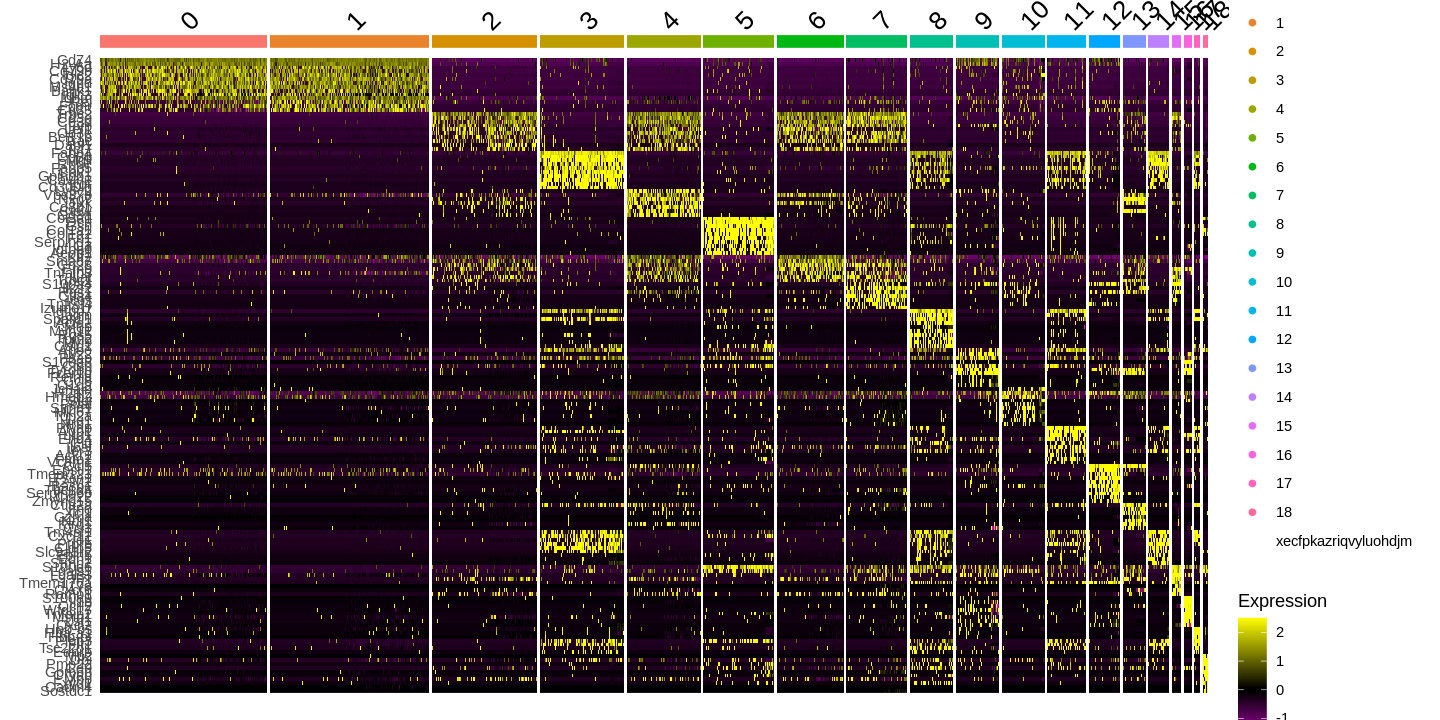

In [ ]:
median_threshold <- median(markers_sig$avg_exp)
top10 <- markers_sig %>% filter(avg_exp>median_threshold) %>%  group_by(cluster) %>% top_n(10, avg_log2FC)
DoHeatmap(object = sc_combined, features = top10$gene, label = TRUE)

Another useful plot is `FeaturePlot` and you can find where the candidate genes are expressed.

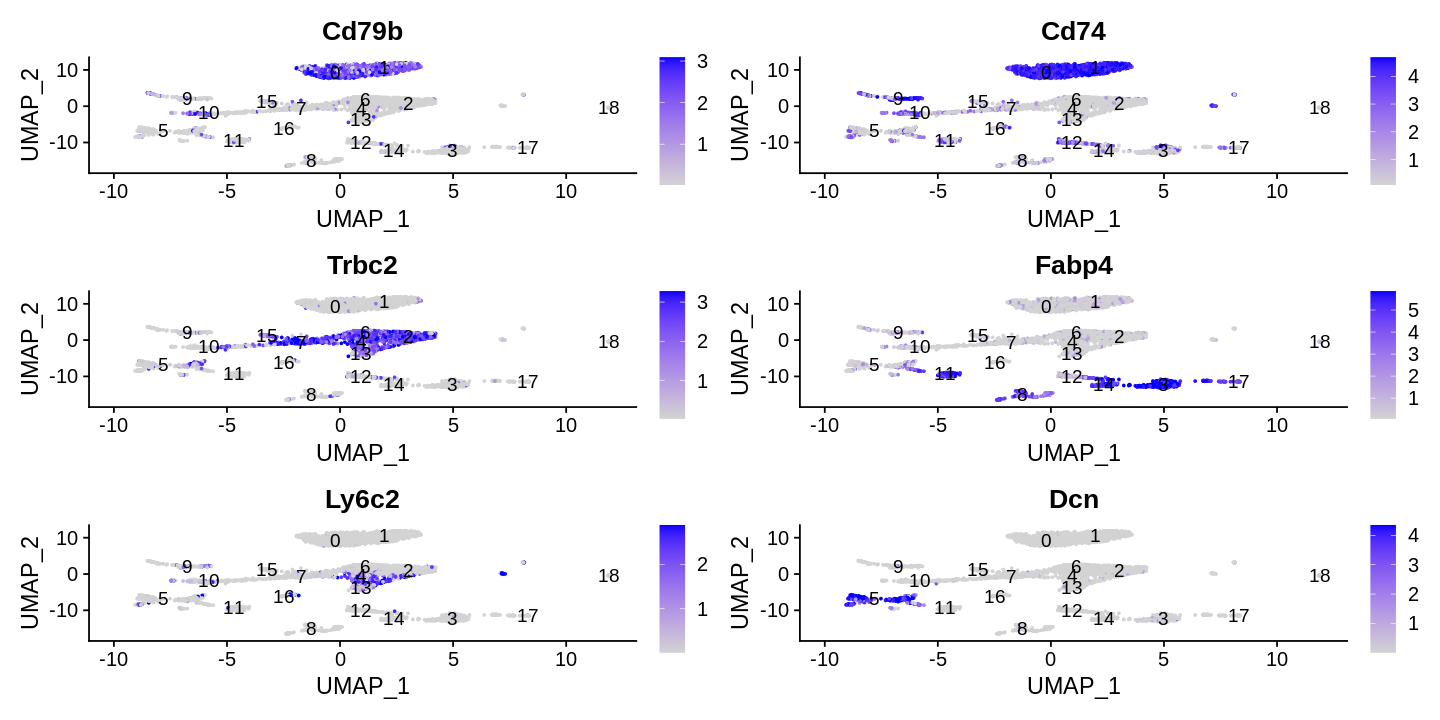

In [ ]:
top1 <- markers_sig %>% filter(avg_exp>median_threshold) %>%  group_by(cluster) %>% top_n(1, avg_log2FC)

FeaturePlot(sc_combined, features = top1$gene[top1$cluster %in% c(0,1,2,3,4,5)], 
            min.cutoff = "q10", max.cutoff = "q90", label = T)

Once you determine each cell type of each cluster, you can annotate cell type of each cluster as follows:

In [ ]:
sc_obj <- RenameIdents(sc_combined,
                       "0" = "B cells", 
                       "1" = "B cells", 
                       "2" = "T cells", 
                       "3" = "Endothelium", 
                       "4" = "T cells", 
                       "5" = "ASC1 Dpp4+", 
                       "6" = "T cells", 
                       "7" = "T cells", 
                       "8" = "Preadipocytes", 
                       "9" = "Monocytes", 
                       "10" = "Proliferating", 
                       "11" = "Icam1+", 
                       "12" = "ASC2 Icam1+", 
                       "13" = "T cells",
                       "14" = "Endothelium",
                       "15" = "T cells",
                       "16" = "Monocytes", 
                       "17" = "Endothelium",
                       "18" = "Unclassified")

`DimPlot` initially showed us a cluster number, but now it shows cell type names.

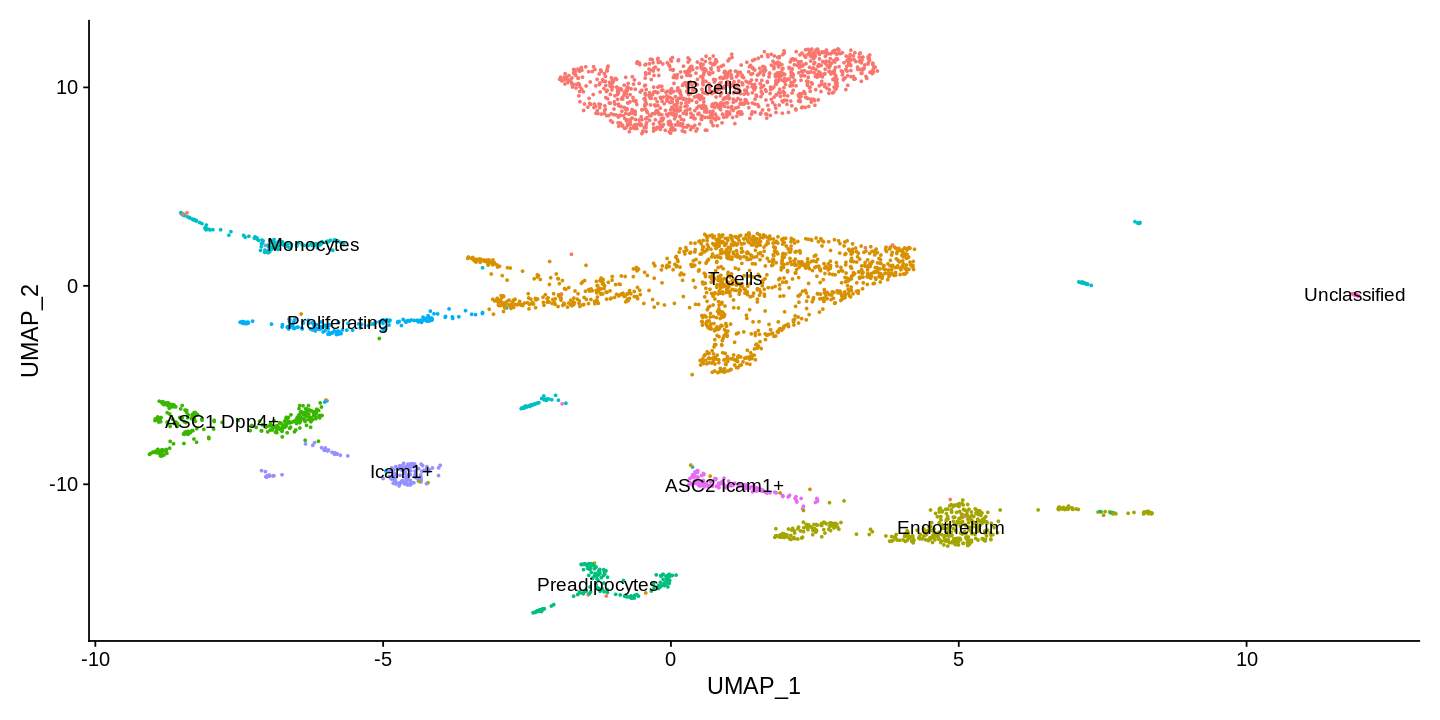

In [ ]:
DimPlot(sc_obj, label = T) + theme(legend.position = "none")

The following code is to perform a DEG analysis of a given cell type. Here, we try to identify the genes differentially expressed in Endothelium by treatment condition.

In [ ]:
sc_obj$celltype <- Idents(sc_obj)
sc_obj$celltype.ident <-
  paste(Idents(sc_obj), sc_obj$orig.ident, sep = "_") # T cells_PBS 
Idents(sc_obj) <- "celltype.ident"

In [ ]:
PBS_vs_DCAN <-
  FindMarkers(
    sc_obj,
    ident.1 = "Endothelium_DCAN",
    ident.2 = "Endothelium_PBS",
    min.pct = 0.25,
    min.diff.pct = 0.1, # the percentage difference
    logfc.threshold = log(1.2)
  )

PBS_vs_DCAN <-
  PBS_vs_DCAN %>% 
  rownames_to_column("gene") %>% 
  filter(p_val_adj < 0.05) %>% 
  arrange(-abs(avg_log2FC)) 

head(PBS_vs_DCAN)

,gene,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Ccl5,6.477076e-13,-1.481592,0.324,0.064,1.295415e-09
2,Cd74,1.538487e-08,-1.472167,1.000,0.317,3.076973e-05
3,H2-Ab1,4.370681e-25,-1.281732,1.000,0.183,8.741361e-22
4,Hba-a1,6.719135e-11,-1.180179,0.338,0.081,1.343827e-07
5,H2-Aa,1.200131e-26,-1.170215,1.000,0.174,2.400262e-23
6,Gm26870,3.762596e-13,1.020048,0.311,0.108,7.525193e-10
